In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import io
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
import time
from datetime import datetime
import os
import random
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from dolfin import *
from mshr import *

/home/haltmayermarc/anaconda3/envs/fenics/lib/python3.11/site-packages/dolfin/jit/jit.py:121: RuntimeWarning: mpi4py.MPI.Session size changed, may indicate binary incompatibility. Expected 32 from C header, got 40 from PyObject
  def compile_class(cpp_data, mpi_comm=MPI.comm_world):


Setting num :14 // Num Element : 482


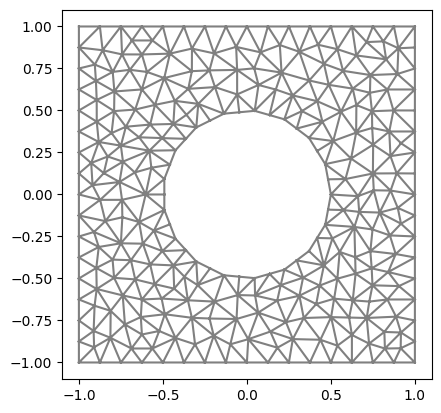

In [3]:
num=14
domain = Rectangle(Point(-1,-1), Point(1,1))-Circle(Point(0,0), 0.5)
mesh = generate_mesh(domain, num)
plot(mesh)
print("Setting num :{} // Num Element : {}".format(num, mesh.cells().shape[0]))

In [3]:
# Define function space: Taylor-Hood element
V = VectorElement('CG', triangle, 2)
Q = FiniteElement('CG', triangle, 1)
TH = V * Q
W = FunctionSpace(mesh, TH)

x_c, y_c = 0.0, 0.0  
class Circle(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (x[0]-x_c)**2 + (x[1]-y_c)**2 < 0.5**2

facet_marker = MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
Circle().mark(facet_marker, 2)

# Define boundary conditions
u_inflow = Expression(("1 - x[1]*x[1]", "0"), degree=1)
noslip = DirichletBC(W.sub(0), (0, 0), "on_boundary && (x[1] >= 0.9 || x[1] < 0.1)")

inflow = DirichletBC(W.sub(0), u_inflow, "on_boundary && x[0] <= 0.1")
circle = DirichletBC(W.sub(0), (0, 0), facet_marker, 2)
outflow = DirichletBC(W.sub(1), 0, "on_boundary && x[0] >= 0.9")
bcs = [noslip, inflow, outflow, circle]

/home/haltmayermarc/anaconda3/envs/fenics/lib/python3.11/site-packages/dolfin/jit/jit.py:46: RuntimeWarning: mpi4py.MPI.Session size changed, may indicate binary incompatibility. Expected 32 from C header, got 40 from PyObject
  if MPI.size(mpi_comm) == 1:


In [4]:
#  Define the variational problem
( u, p ) = TrialFunctions ( W )
( v, q ) = TestFunctions ( W )
s = Function(W, name="State")

mu = 0.1
a = ( 0.5 * mu * inner ( grad ( v ) + grad ( v ).T, grad ( u ) + grad ( u ).T ) \
    - div ( v )* p + q * div ( u ) ) * dx

# Assemble matrix
A = assemble(a)
for bc in bcs:
    bc.apply(A)
matrix = A.array()

L = inner(Constant((0,0)), v) * dx
A, b = assemble_system(a, L, bcs)
matrix = A.array()

solve(A, s.vector(), b)
u, p = s.split(deepcopy=True)  # u is the vector Function (velocity), p is scalar (pressure)
u.rename("Velocity", "")
p.rename("Pressure", "")

In [12]:
ne=mesh.cells().shape[0]
dofmap = W.dofmap()
p = W.tabulate_dof_coordinates()
ng = p.shape[0]

In [13]:
c=[]
for i in range(ne):
    c.append(dofmap.cell_dofs(i))
c=np.asarray(c)

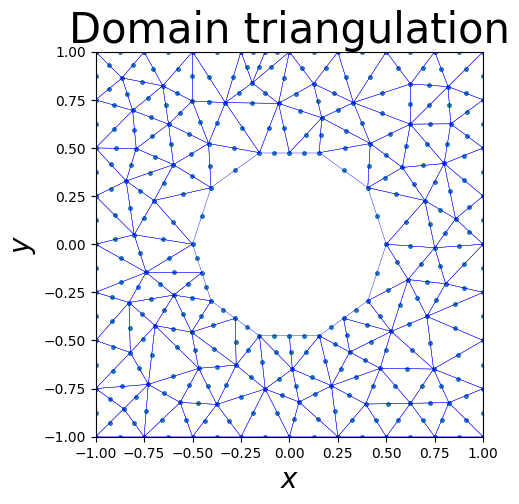

In [15]:
fig=plt.figure(figsize=(5,5))
plt.title("Domain triangulation", fontsize=30)
plt.scatter(p[:,0],p[:,1], s=5)
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel(r'$x$', fontsize=20)
plt.ylabel(r'$y$', fontsize=20)
for i in range(len(c)):
    plt.plot(p[c[i][0:3]][:,0],p[c[i][0:3]][:,1],c='b', linewidth=0.3)
    plt.plot(np.array([p[c[i][2]],p[c[i][0]]])[:,0],np.array([p[c[i][2]],p[c[i][0]]])[:,1],c='b', linewidth=0.3)

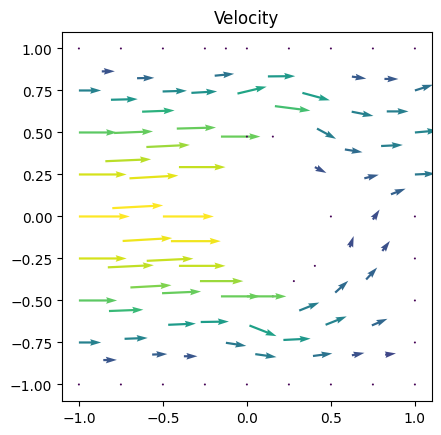

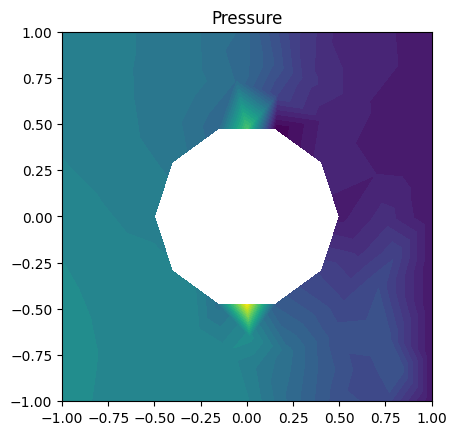

In [5]:
plot(u, title="Velocity")
plt.figure()
plot(p, title="Pressure")
plt.show()

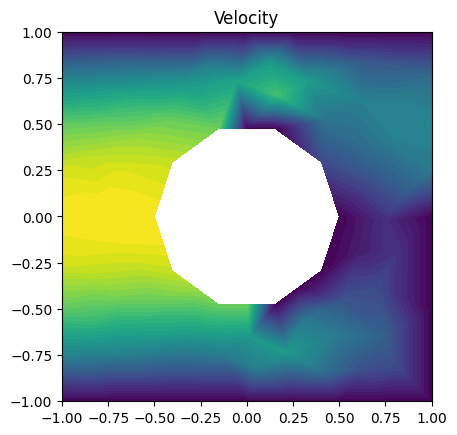

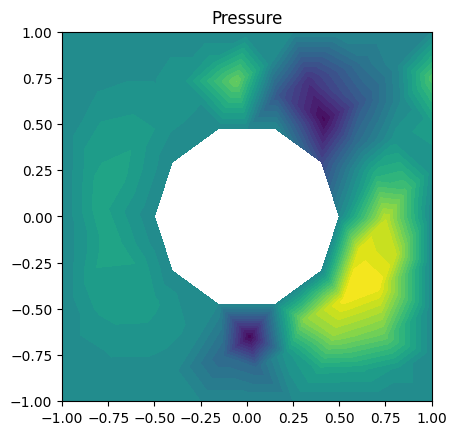

In [6]:
plot(u.sub(0), title="Velocity")
plt.figure()
plot(u.sub(1), title="Pressure")
plt.show()

In [7]:
mesh=np.load("data_ordered/P2x1_ne154_stokes.npz", allow_pickle=True)
num_element, num_pts, p = mesh['ne'], mesh['ng'], mesh['p']
idx_sol = mesh['idx_sol']
matrix=mesh['matrix']

In [8]:
np.linalg.cond(matrix)

np.float64(542.9439570445933)

In [9]:
# Preconditioning
from scipy.sparse import identity
from scipy.sparse import diags
from scipy.sparse.linalg import onenormest

def spai(A, m):
    """Perform m step of the SPAI iteration."""

    n = A.shape[0]

    ident = identity(n, format='csr')
    alpha = 2 / onenormest(A @ A.T)
    M = alpha * A

    for index in tqdm(range(m)):
        C = A @ M
        G = ident - C
        AG = A @ G
        trace = (G.T @ AG).diagonal().sum()
        alpha = trace / np.linalg.norm(AG.data)**2
        M = M + alpha * G

    return M

In [10]:
precond = spai(matrix,1000)
np.linalg.cond(matrix @ precond)

100%|██████████| 1000/1000 [01:07<00:00, 14.71it/s]


np.float64(1.0112000077249945)

In [20]:
import numpy as np
data = np.load("/home/haltmayermarc/FEONet_Stokes/FEONet-square-with-hole/data_ordered/train/1000512.pkl", allow_pickle=True)

In [21]:
data[0][0].shape

(2549,)

In [14]:
mesh = np.load("/home/haltmayermarc/FEONet_Stokes/FEONet-square-with-hole/data_ordered/P2x1_ne512_stokes.npz")

In [19]:
mesh["p"].shape

(2549, 2)

/tmp/ipykernel_4142733/1703270580.py:6: RuntimeWarning: invalid value encountered in divide
  return (1 - np.cos(np.pi * a)) / (np.pi * a)
/tmp/ipykernel_4142733/1703270580.py:9: RuntimeWarning: invalid value encountered in divide
  return np.sin(np.pi * a) / (np.pi * a)


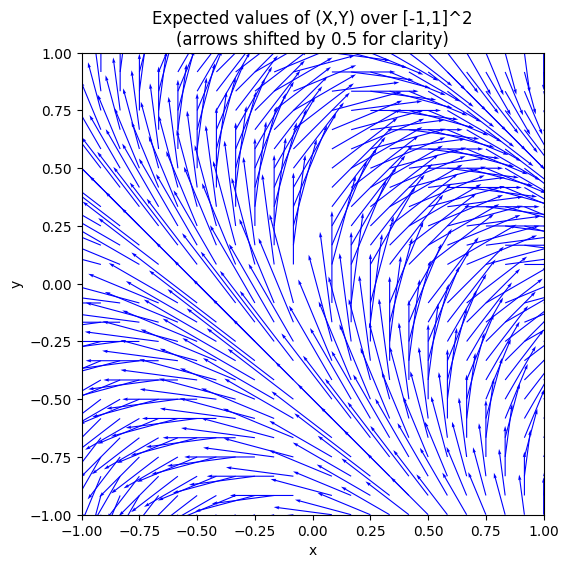

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# helper functions
def S(a):
    return (1 - np.cos(np.pi * a)) / (np.pi * a)
    
def C(a):
    return np.sin(np.pi * a) / (np.pi * a)

# vectorized versions
S_vec = np.vectorize(S)
C_vec = np.vectorize(C)

def E_X(x, y):
    return 0.5 + S(x)*C(y) + C(x)*S(y)

def E_Y(x, y):
    return 0.5 + C(x)*C(y) - S(x)*S(y)

# grid of points in [-1,1]^2
xs = np.linspace(-1, 1, 25)
ys = np.linspace(-1, 1, 25)
X, Y = np.meshgrid(xs, ys)

# compute expected values at each point
EX = E_X(X, Y)
EY = E_Y(X, Y)

# plot vector field
plt.figure(figsize=(6,6))
plt.quiver(X, Y, EX-0.5, EY-0.5, angles='xy', scale=5, color='blue')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Expected values of (X,Y) over [-1,1]^2\n(arrows shifted by 0.5 for clarity)')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.gca().set_aspect('equal')
plt.show()

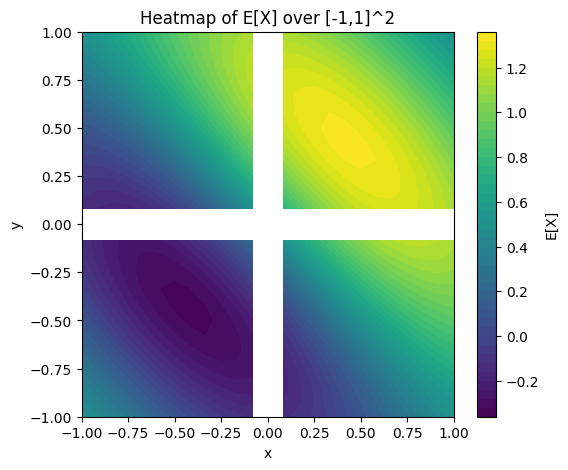

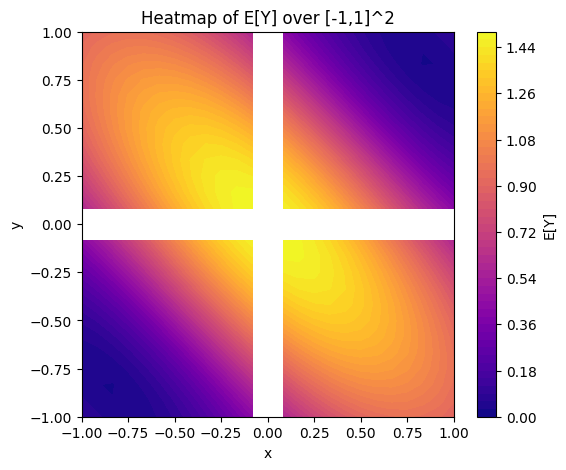

In [4]:
# --- Plot 2: Heatmap of E[X] ---
plt.figure(figsize=(6,5))
plt.contourf(X, Y, EX, levels=50, cmap='viridis')
plt.colorbar(label='E[X]')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Heatmap of E[X] over [-1,1]^2')
plt.show()


# --- Plot 3: Heatmap of E[Y] ---
plt.figure(figsize=(6,5))
plt.contourf(X, Y, EY, levels=50, cmap='plasma')
plt.colorbar(label='E[Y]')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Heatmap of E[Y] over [-1,1]^2')
plt.show()

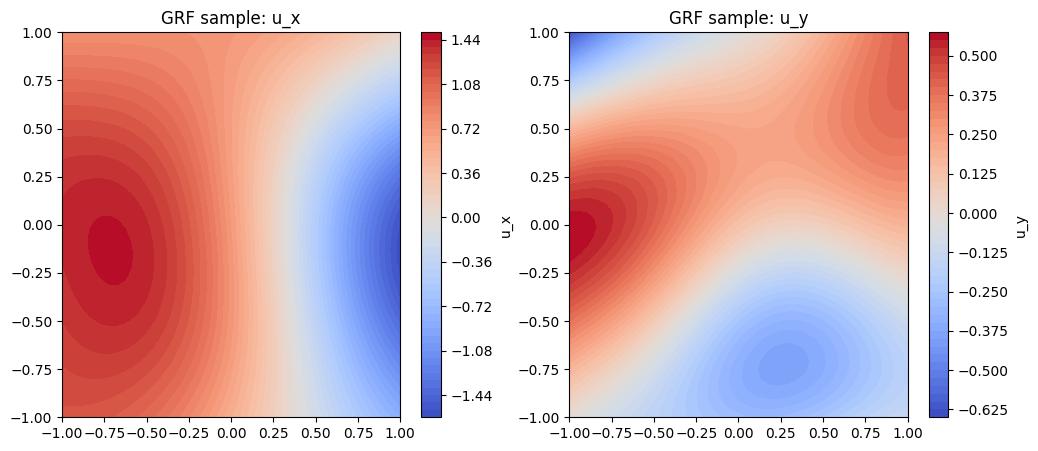

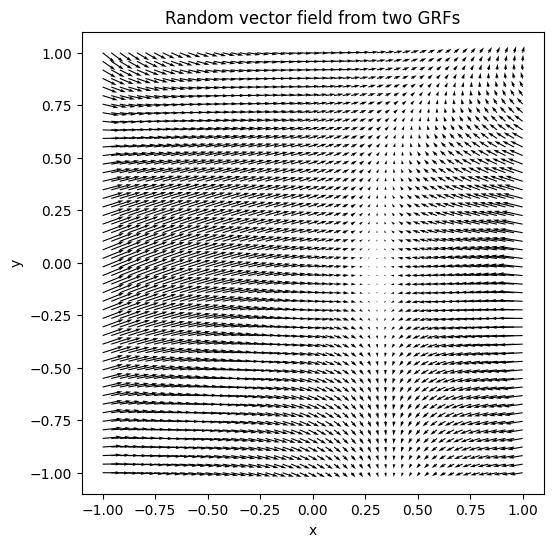

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from scipy.linalg import cholesky

# --- Kernel and GRF sampling ---
def rbf_kernel(X, length_scale, variance):
    dists = cdist(X, X, metric='euclidean')
    return variance * np.exp(-0.5 * (dists / length_scale)**2)

def generate_grf_sample(coords, length_scale=1.0, variance=1.0):
    K = rbf_kernel(coords, length_scale, variance)
    K += 1e-8 * np.eye(K.shape[0])
    L = cholesky(K, lower=True)
    u_x = L @ np.random.randn(coords.shape[0])
    u_y = L @ np.random.randn(coords.shape[0])
    return u_x, u_y

# --- Coordinates: 2D grid ---
xs = np.linspace(-1, 1, 50)
ys = np.linspace(-1, 1, 50)
X, Y = np.meshgrid(xs, ys)
coords = np.column_stack([X.ravel(), Y.ravel()])

# Sample GRFs
u_x, u_y = generate_grf_sample(coords, length_scale=1.0, variance=0.6)
U_x = u_x.reshape(X.shape)
U_y = u_y.reshape(Y.shape)

# --- Plot heatmaps ---
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.contourf(X, Y, U_x, levels=50, cmap='coolwarm')
plt.colorbar(label='u_x')
plt.title('GRF sample: u_x')

plt.subplot(1,2,2)
plt.contourf(X, Y, U_y, levels=50, cmap='coolwarm')
plt.colorbar(label='u_y')
plt.title('GRF sample: u_y')
plt.show()

# --- Plot vector field (u_x,u_y) ---
plt.figure(figsize=(6,6))
plt.quiver(X, Y, U_x, U_y, angles='xy', scale=30, color='black')
plt.title('Random vector field from two GRFs')
plt.xlabel('x')
plt.ylabel('y')
plt.gca().set_aspect('equal')
plt.show()


In [58]:
u_x, u_y = generate_grf_sample(coords, length_scale=1.0, variance=0.6)

In [65]:
resol_in =64
grid_x=torch.linspace(-1,1,resol_in)
input_grid=torch.cartesian_prod(grid_x,grid_x)
u_x, u_y = generate_grf_sample(input_grid, length_scale=1.0, variance=0.6)
value_f = torch.stack([torch.tensor(u_x),torch.tensor(u_y)],dim=1).reshape(-1,2,resol_in,resol_in)
value_f.shape

torch.Size([1, 2, 64, 64])

In [ ]:
# make grid (like torch.cartesian_prod)
grid_x = np.linspace(-1, 1, resol_in)
xx, yy = np.meshgrid(grid_x, grid_x, indexing="ij")   # (resol_in, resol_in)
input_grid = np.column_stack([xx.ravel(), yy.ravel()])  # (resol_in**2, 2)

# GRF sample
u_x, u_y = generate_grf_sample(input_grid, length_scale=1.0, variance=0.6)

# stack + reshape -> (2, resol_in, resol_in)
value_f = np.stack([u_x, u_y], axis=0)

In [70]:
input_grid.shape

(4096, 2)

In [74]:
data = np.load("/home/haltmayermarc/FEONet_Stokes/FEONet-square-with-hole_new/data_ordered/channel_flow/grf/train/1000N154.pkl",allow_pickle=True)

In [75]:
data[0][1].shape

(2, 4096)

In [2]:
import numpy as np
mesh = np.load("/home/haltmayermarc/FEONet_Stokes/FEONet-square-with-hole_new/data_ordered/P2x1_ne512_stokes_channel_flow_BC_sincos.npz", allow_pickle=True)

In [2]:
matrix = mesh['matrix']
cond_number = np.linalg.cond(matrix)

In [3]:
cond_number

np.float64(1750.4043463120431)

In [6]:
# Preconditioning
from tqdm import tqdm
from scipy.sparse import identity
from scipy.sparse import diags
from scipy.sparse.linalg import onenormest

def spai(A, m):
    """Perform m step of the SPAI iteration."""

    n = A.shape[0]

    ident = identity(n, format='csr')
    alpha = 2 / onenormest(A @ A.T)
    M = alpha * A

    for index in tqdm(range(m)):
        C = A @ M
        G = ident - C
        AG = A @ G
        trace = (G.T @ AG).diagonal().sum()
        alpha = trace / np.linalg.norm(AG.data)**2
        M = M + alpha * G

    return M

In [7]:
precond = spai(matrix, 10000)

100%|██████████| 10000/10000 [39:42<00:00,  4.20it/s]


In [8]:
new_mat = matrix @ precond
np.linalg.cond(new_mat)

np.float64(1.0000005591709644)

In [9]:
np.save("/home/haltmayermarc/FEONet_Stokes/FEONet-square-with-hole_new/precond_512_channel_flow.npy", precond)

In [3]:
mesh = np.load("/home/haltmayermarc/FEONet_Stokes/FEONet-square-with-hole_new/data_ordered/P2x1_ne154_stokes_channel_flow_BC_grf.npz",allow_pickle=True)

In [12]:
idx_sol = mesh["idx_sol"]
pos_all = mesh["p"]

In [14]:
pos_u = pos_all[idx_sol[0]]
pos_u.shape

(356, 2)

In [ ]:
u_x = mesh["train_forcing_term"][0][:len(idx_sol[0])]
grid_x = np.linspace(-1, 1, 50)
xx, yy = np.meshgrid(grid_x, grid_x, indexing="ij")
input_grid = np.column_stack([xx.ravel(), yy.ravel()])
input_grid.shape
from scipy.interpolate import griddata
u_new = griddata(pos_u, u_x, input_grid, method='cubic')

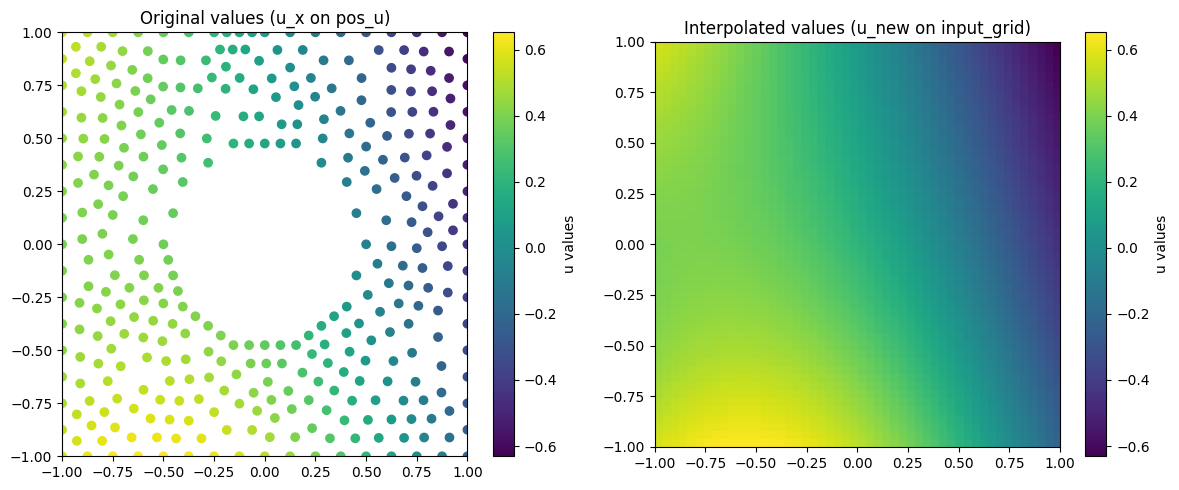

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# pos_u : (num_pts, 2)
# u_x   : (num_pts,)
# input_grid : (N^2, 2)
# u_new : (N^2,)  -- interpolated on input_grid

# Reshape u_new back to grid
N = int(np.sqrt(len(input_grid)))
u_new_grid = u_new.reshape(N, N)

# Shared color limits
vmin = min(np.nanmin(u_x), np.nanmin(u_new_grid))
vmax = max(np.nanmax(u_x), np.nanmax(u_new_grid))

plt.figure(figsize=(12, 5))

# Plot u_x directly on pos_u
plt.subplot(1, 2, 1)
sc = plt.scatter(pos_u[:, 0], pos_u[:, 1], c=u_x,
                 cmap="viridis", vmin=vmin, vmax=vmax)
plt.colorbar(sc, label="u values")
plt.title("Original values (u_x on pos_u)")
plt.xlim(-1, 1)
plt.ylim(-1, 1)

# Plot interpolated field u_new on grid
plt.subplot(1, 2, 2)
plt.imshow(u_new_grid.T, extent=(-1, 1, -1, 1), origin="lower",
           cmap="viridis", vmin=vmin, vmax=vmax, aspect="equal")
plt.colorbar(label="u values")
plt.title("Interpolated values (u_new on input_grid)")

plt.tight_layout()
plt.show()
